
Classification Report for SVM (linear):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           2       0.77      1.00      0.87        23

    accuracy                           0.77        30
   macro avg       0.38      0.50      0.43        30
weighted avg       0.59      0.77      0.67        30

Regular CV Score: 0.5714285714285714
Stratified CV Score: 0.5714285714285714

Classification Report for SVM (rbf):
              precision    recall  f1-score   support

           0       1.00      0.43      0.60         7
           2       0.85      1.00      0.92        23

    accuracy                           0.87        30
   macro avg       0.93      0.71      0.76        30
weighted avg       0.89      0.87      0.85        30

Regular CV Score: 0.7
Stratified CV Score: 0.6571428571428573

Classification Report for SVM (poly):
              precision    recall  f1-score   support

           0       0.00      0.00 

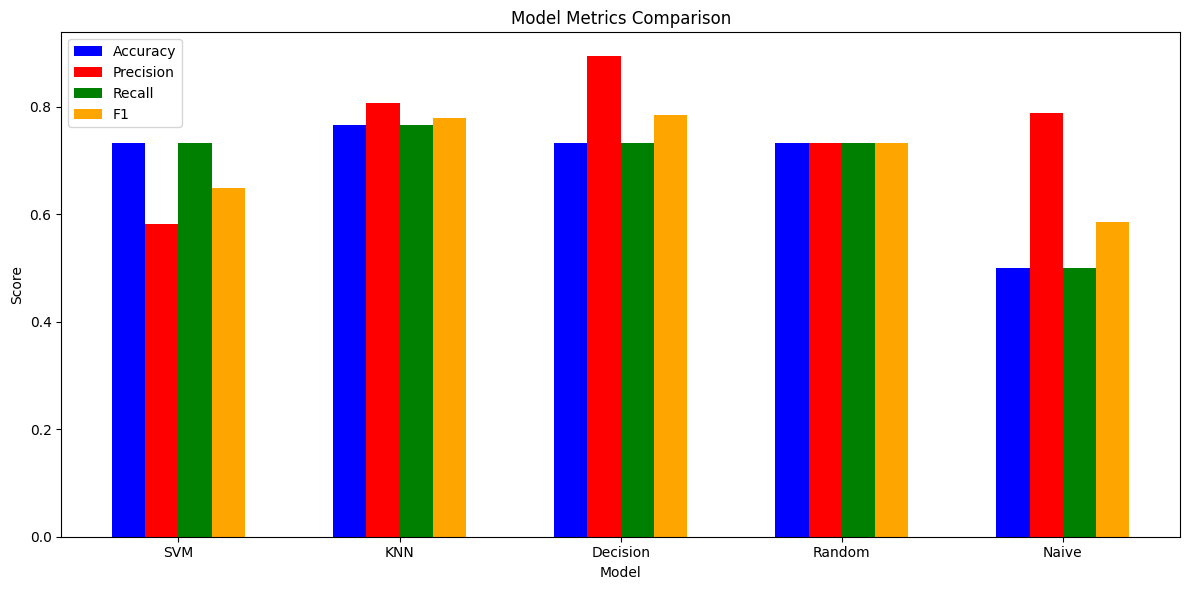

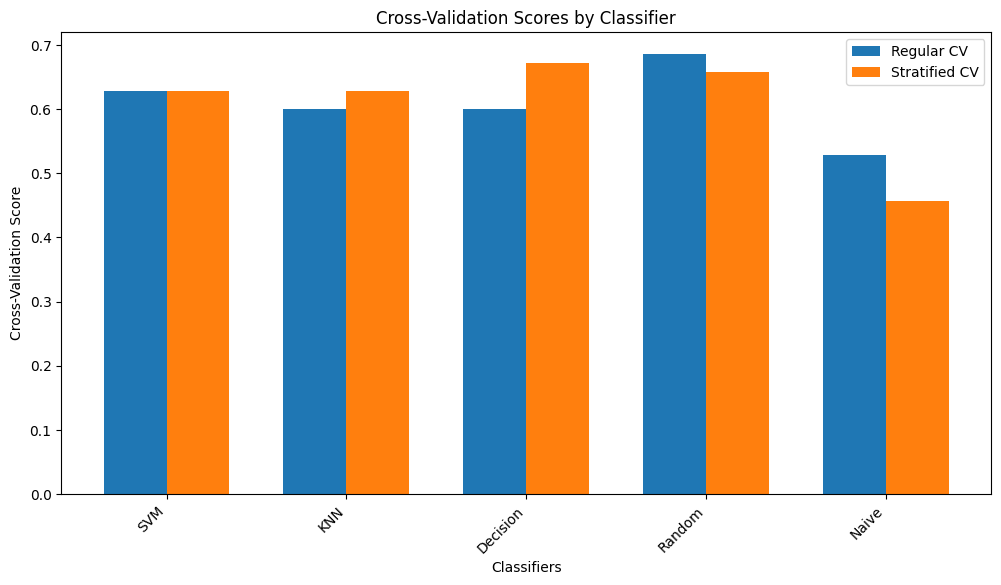

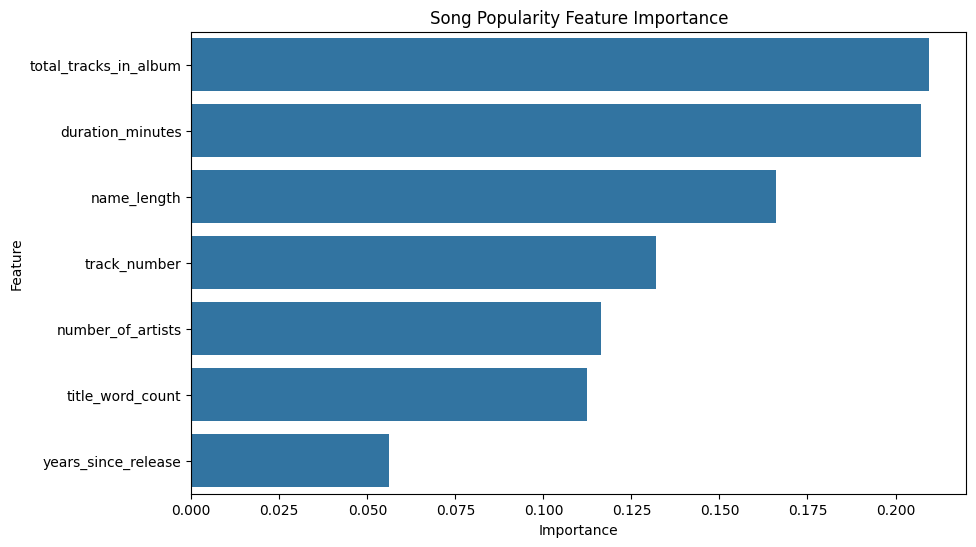

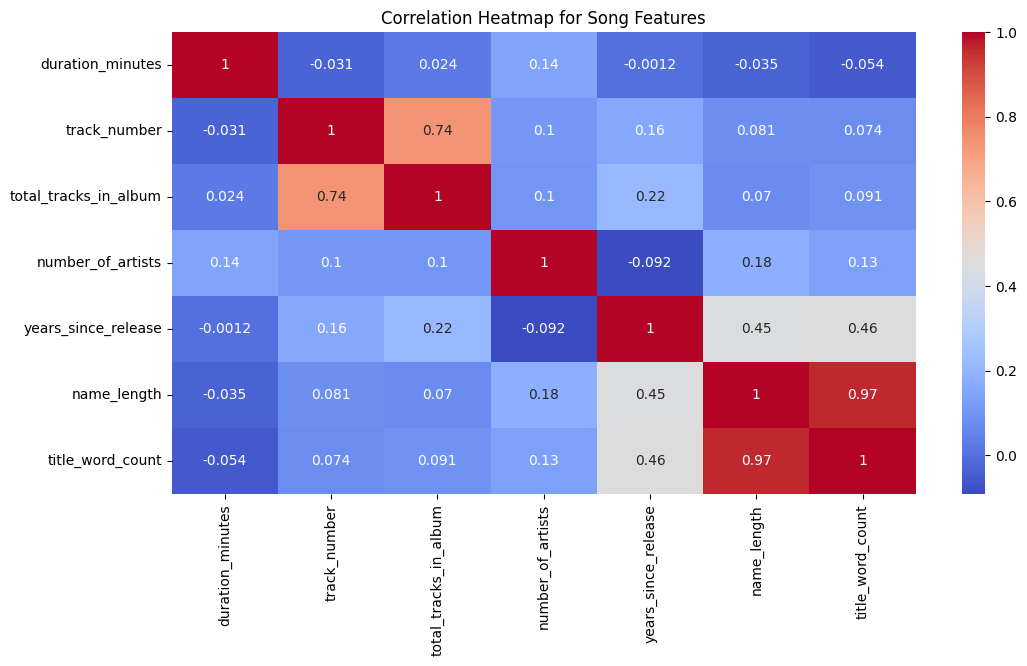

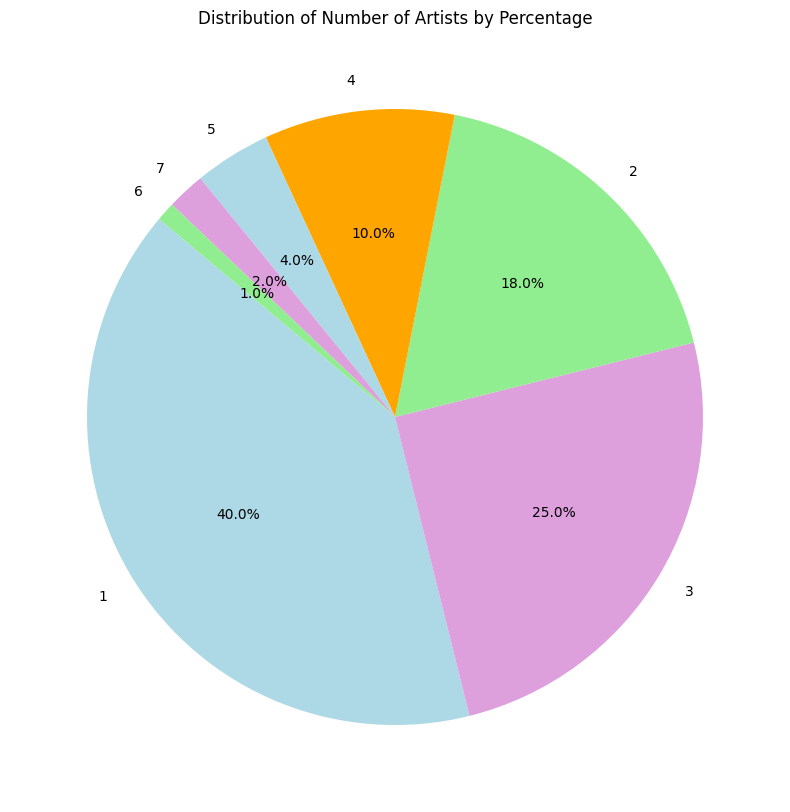

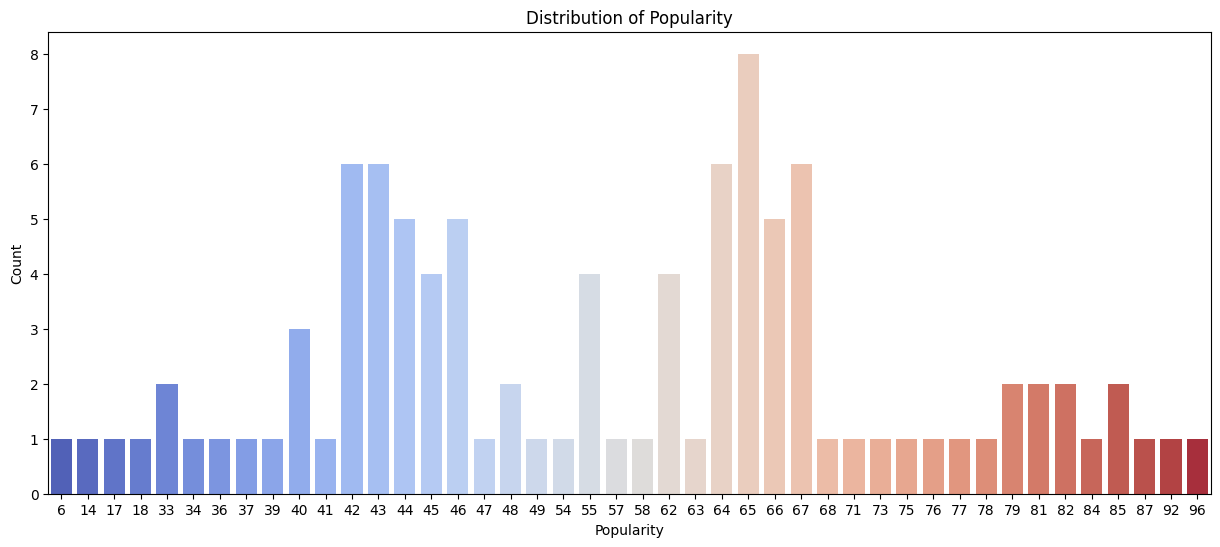

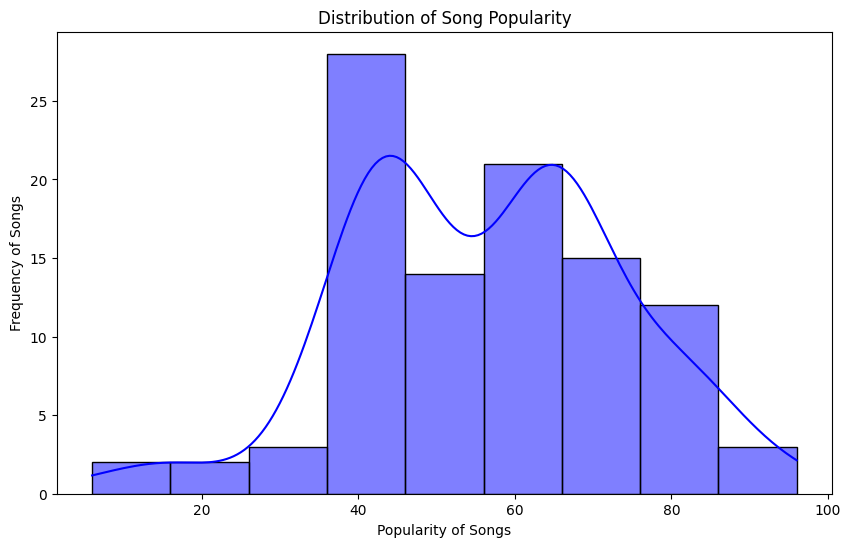



popularity_class
Low       35
Medium    35
High      30
Name: count, dtype: int64



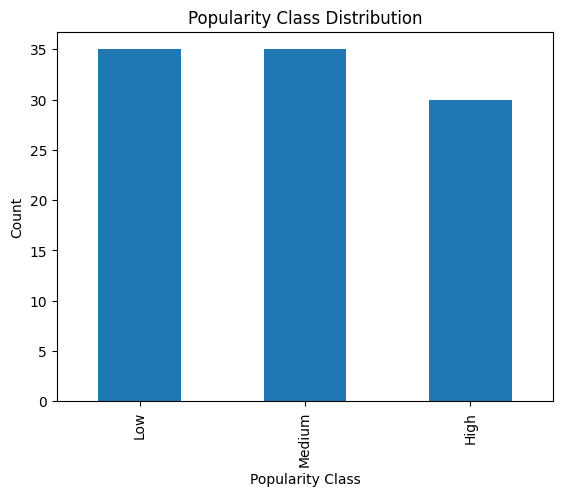

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score
import pickle
import warnings
warnings.filterwarnings('ignore')

#load data
url = 'https://raw.githubusercontent.com/ej-284/Song-Popularity-Prediction/refs/heads/main/spotify_track_features.csv'
df = pd.read_csv(url)

def categorize_popularity(pop_score):
  if pop_score <= 33:
    return 'Low'
  elif pop_score <= 66:
    return 'Medium'
  else:
    return 'High'

df['popularity_class'] = df['popularity'].apply(categorize_popularity)

#prepare features and target
x = df.drop(['popularity', 'popularity_class', 'available_markets_count',
             'name', 'album_name', 'album_type', 'explicit',
             'is_local', 'type', 'release_date', 'primary_artist_id',
             'album_id', 'spotify_url', 'track_id', 'artist', 'duration_ms',
             'disc_number'], axis=1)
le = LabelEncoder()
y = le.fit_transform(df['popularity_class'])

#create feature groups for analysis
song_features = ['duration_minutes', 'track_number', 'total_tracks_in_album', 'number_of_artists',
                 'years_since_release', 'name_length', 'title_word_count']

#train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

#scale the features
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

#save scaler
with open('scaler.pkl', 'wb') as f:
  pickle.dump(scaler, f)

#initialize classifiers
classifiers = {
                'SVM (linear)': SVC(kernel = 'linear', probability = True, random_state = 42),
                'SVM (rbf)': SVC(kernel = 'rbf', probability = True, random_state = 42),
                'SVM (poly)': SVC(kernel = 'poly', probability = True, random_state = 42),
                'SVM (sigmoid)': SVC(kernel = 'sigmoid', probability = True, random_state = 42),
                'KNN': KNeighborsClassifier(n_neighbors = 5),
                'Decision Tree': DecisionTreeClassifier(random_state = 42),
                'Random Forest': RandomForestClassifier(random_state = 42),
                'Naive Bayes': GaussianNB()
            }

#K-fold Cross Validation
def perform_cross_val(x, y, classifier, cv_type = 'regular', n_splits = 5):
  if cv_type == 'regular':
    kf = KFold(n_splits = n_splits, shuffle = True, random_state = 42)
  else:
    kf = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = 42)

  scores = []
  for train_index, val_index in kf.split(x, y):
    x_train_fold, x_val_fold = x[train_index], x[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]

    classifier.fit(x_train_fold, y_train_fold)
    scores.append(classifier.score(x_val_fold, y_val_fold))

  return np.mean(scores)

#function to plot model metrics comparison
def plot_model_metrics_comparison(y_true, predictions_dict):
  metrics = {
              'Accuracy': [],
              'Precision': [],
              'Recall': [],
              'F1 Score': []
  }

  model_names = list(predictions_dict.keys())
  for model_name, y_pred in predictions_dict.items():
    metrics['Accuracy'].append(accuracy_score(y_true, y_pred))
    metrics['Precision'].append(precision_score(y_true, y_pred, average = 'weighted'))
    metrics['Recall'].append(recall_score(y_true, y_pred, average = 'weighted'))
    metrics['F1 Score'].append(f1_score(y_true, y_pred, average = 'weighted'))

  print()
  fig, ax = plt.subplots(figsize = (12, 6))
  bar_width = 0.15
  r1 = np.arange(len(model_names))
  r2 = [x + bar_width for x in r1]
  r3 = [x + bar_width for x in r2]
  r4 = [x + bar_width for x in r3]

  plt.bar(r1, metrics['Accuracy'], width=bar_width, label='Accuracy', color='blue')
  plt.bar(r2, metrics['Precision'], width=bar_width, label='Precision', color='red')
  plt.bar(r3, metrics['Recall'], width=bar_width, label='Recall', color='green')
  plt.bar(r4, metrics['F1 Score'], width=bar_width, label='F1', color='orange')

  plt.xlabel('Model')
  plt.ylabel('Score')
  plt.title('Model Metrics Comparison')
  plt.xticks([r + bar_width * 1.5 for r in range(len(model_names))], model_names)
  plt.legend()
  plt.tight_layout()
  plt.show()
  print()
  print()

#train models and perform cross-validation
cross_val_scores = {}
predictions_dict = {}
for name, classifier in classifiers.items():
  regular_cv_score = perform_cross_val(x_train_scaled, y_train, classifier, cv_type = 'regular')
  stratified_cv_score = perform_cross_val(x_train_scaled, y_train, classifier, cv_type = 'stratified')

  classifier.fit(x_train_scaled, y_train)
  y_pred = classifier.predict(x_test_scaled)

  short_name = name.split()[0] if len(name.split()) > 1 else name
  predictions_dict[short_name] = y_pred

  with open(f'{name.lower().replace(" ", "_")}.pkl', 'wb') as f:
    pickle.dump(classifier, f)
  print(f'\nClassification Report for {name}:')
  print(classification_report(y_test, y_pred))
  print(f'Regular CV Score: {regular_cv_score}')
  print(f'Stratified CV Score: {stratified_cv_score}')

  cross_val_scores[short_name] = {
                                  'Regular CV Score': regular_cv_score,
                                  'Stratified CV Score': stratified_cv_score
                             }

#generate metrics comparison plot
plot_model_metrics_comparison(y_test, predictions_dict)

#visualization of cross-validation scores
plt.figure(figsize = (12, 6))
x = np.arange(len(cross_val_scores))
width = 0.35
plt.bar(x - width/2, [score['Regular CV Score'] for score in cross_val_scores.values()], width, label = 'Regular CV')
plt.bar(x + width/2, [score['Stratified CV Score'] for score in cross_val_scores.values()], width, label = 'Stratified CV')

plt.xlabel('Classifiers')
plt.ylabel('Cross-Validation Score')
plt.title('Cross-Validation Scores by Classifier')
plt.xticks(x, cross_val_scores.keys(), rotation = 45, ha = 'right')
plt.legend()
plt.show()
print()
print()

#feature importance visualization for Random Forest
rf_classifier = classifiers['Random Forest']
feature_importance = pd.DataFrame({
                                     'Feature': x_train.columns,
                                     'Importance': rf_classifier.feature_importances_
                                })
feature_importance = feature_importance.sort_values(by = 'Importance', ascending = False)

plt.figure(figsize = (10, 6))
sns.barplot(x = 'Importance', y = 'Feature', data = feature_importance)
plt.title('Song Popularity Feature Importance')
plt.show()
print()
print()

#add correlation heatmap for song features
plt.figure(figsize = (12, 6))
sns.heatmap(df.loc[:, song_features].corr(), annot = True, cmap = 'coolwarm')
plt.title('Correlation Heatmap for Song Features')
plt.show()
print()
print()

#distribution of the number of artists
num_of_artists_counts = df['number_of_artists'].value_counts()
#plot the pie chart
plt.figure(figsize=(10, 10))
plt.pie(num_of_artists_counts, labels=num_of_artists_counts.index, autopct='%1.1f%%', startangle=140, colors=['lightblue', 'plum', 'lightgreen', 'orange'])
plt.title('Distribution of Number of Artists by Percentage')
plt.show()
print()
print()

#bar plot for popularity
plt.figure(figsize=(15, 6))
sns.countplot(x='popularity', data=df, palette='coolwarm')
plt.title('Distribution of Popularity')
plt.xlabel('Popularity')
plt.ylabel('Count')
plt.show()
print()
print()

#distribution of popularity
plt.figure(figsize = (10, 6))
sns.histplot(df['popularity'], bins='auto', kde = True, color = 'blue')
plt.title('Distribution of Song Popularity')
plt.xlabel('Popularity of Songs')
plt.ylabel('Frequency of Songs')
plt.show()
print()
print()

#distribution of popularity classes
df['popularity_class'] = df['popularity'].apply(categorize_popularity)
df['popularity_class'] = pd.qcut(df['popularity'], q=3, labels=['Low', 'Medium', 'High'])
#check the distribution of the categories
print(df['popularity_class'].value_counts())
print()

df['popularity_class'].value_counts().plot(kind='bar')
plt.title('Popularity Class Distribution')
plt.xlabel('Popularity Class')
plt.ylabel('Count')
plt.show()

In [83]:
#function for predicting with user input
def predict_song_popularity(user_data):
  with open('random_forest.pkl', 'rb') as f:
    rf_classifier = pickle.load(f)
  with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

  user_df = pd.DataFrame([user_data])
  user_data_scaled = scaler.transform(user_df)

  prediction = rf_classifier.predict(user_data_scaled)
  probability = rf_classifier.predict_proba(user_data_scaled)
  return le.inverse_transform(prediction)[0], probability[0]

#convert time to float
def time_to_float():
    # Get time input from the user
    time_input = input()

    try:
        # Split the input into parts
        time_parts = [int(part) for part in time_input.split(":")]

        # Extract hours, minutes, and seconds
        hours = time_parts[0]
        minutes = time_parts[1]
        seconds = time_parts[2] if len(time_parts) == 3 else 0  # Default seconds to 0 if not provided

        # Convert to float (hours as a decimal)
        time_float = hours + (minutes / 60) + (seconds / 3600)

        print(f"The time {time_input} as a float is: {time_float:.2f}")
        return time_float
    except ValueError:
        print("Invalid time format. Please enter the time in HH:MM or HH:MM:SS format.")
        return time_to_float()

#function to get user input
def get_user_input():
  user_data = {}
  print('Please enter the following information:')

  for feature in song_features:
    if feature == 'duration_minutes':
      print(f'Enter a time value for {feature}:')
      user_data[feature] = time_to_float()
    else:
      user_data[feature] = float(input(f'{feature}:'))
  return user_data

user_input = get_user_input()
prediction, probability = predict_song_popularity(user_input)
print(f"\nPredicted song popularity: {prediction}")
print(f"Probability distribution: {probability}")

Please enter the following information:
Enter a time value for duration_minutes:
2:39
The time 2:39 as a float is: 2.65
track_number:2
total_tracks_in_album:10
number_of_artists:1
years_since_release:0
name_length:7
title_word_count:1

Predicted song popularity: Medium
Probability distribution: [0.26 0.3  0.44]
